In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from nilearn.image import concat_imgs, mean_img
from nilearn.plotting import plot_stat_map, plot_design_matrix, plot_contrast_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn.reporting import get_clusters_table
from nilearn.glm.thresholding import threshold_stats_img

from bids import BIDSLayout

In [2]:
# ACNets project folder (to access data and resources)
project_dir = Path('.')

# you need to download preprocessed subject data before running the notebook:
# datalad get derivatives/fmriprep/sub-NVGP01* -r

In [17]:
layout = BIDSLayout(project_dir / 'data/julia2018',
                    derivatives=True,
                    database_path=project_dir / 'tmp/pybids_cache/julia2018')

task = 'attention'
sessions = ['1','2']
subjects = layout.get_subject()

fmri_images = layout.get(task=task,
                         desc='preproc',
                         subject=subjects,
                         session=sessions,
                         suffix='bold',
                         scope='fmriprep',
                         extension='nii.gz',
                         return_type='filename')

mask_images = layout.get(task=task,
                         desc='brain',
                         subject=subjects,
                         session=sessions,
                         suffix='mask',
                         scope='fmriprep',
                         extension='nii.gz',
                         return_type='filename')

confounds_files = layout.get(task=task,
                             desc='confounds',
                             subject=subjects,
                             session=sessions,
                             suffix='timeseries',
                             scope='fmriprep',
                             extension='tsv',
                             return_type='filename')

events_files = layout.get(task=task,
                          subject=subjects,
                          session=sessions,
                          suffix='events',
                          scope='self',
                          extension='tsv',
                          return_type='filename')


confounds_cols = ['trans_x', 'trans_y', 'trans_z',
                  'rot_x', 'rot_y', 'rot_z',
                  'global_signal',
                  'a_comp_cor_00', 'a_comp_cor_01']

TR = layout.get_tr(task=task,subject=subjects, session=sessions)


In [21]:
# %% load data

session = '1'
subject = ['NVGP01']

fmri_images = layout.get(task=task,
                         desc='preproc',
                         subject=subject,
                         session=session,
                         suffix='bold',
                         scope='fmriprep',
                         extension='nii.gz',
                         return_type='filename')

events_files = layout.get(task=task,
                          subject=subject,
                          session=session,
                          suffix='events',
                          scope='self',
                          extension='tsv',
                          return_type='filename')


# fmri_image = concat_imgs(fmri_images)
# mean_image = mean_img(fmri_image)

events = []
for ef in events_files:
    events.append(pd.read_table(ef))
# # TODO filter events


# apply Gaussian kernel of 8mm (foecker was 5mm) and band-pass filtering
# run-specific intercept
# convolve with canonical HRF
# GLM predictor = target onset of different trial types
# additional regressors = error, post-error, timeout, and outlier trials

# combine both sessions as foecker2018 found no relevant differences acorss sessions.
# analyze all trials (correct and incorrect)
# foecker2018 also used SOA as regressor
# Emiliano used 90-ROIs from Shirer for resting state https://findlab.stanford.edu/functional_ROIs.html
# a more comperhensive atlas would be willard which contains 499 ROIs
# Emiliano used filtering of ([0.008 0.09]) 

# planned contrasts:
#   - invalid vs valid
#   - left vs right ( * valid vs invalid)
#   - interaction of cue vs target_position
#   - distractors????


In [62]:
# fit GLM

fmri_glm = FirstLevelModel(t_r=TR,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=.01)

fmri_glm = fmri_glm.fit(fmri_images[0], events[0])


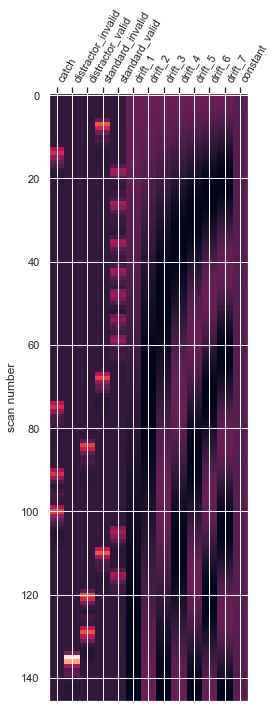

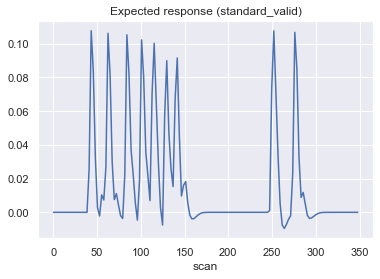

In [65]:
# plot design matrix
# row=time, col=predictors
design_matrix = fmri_glm.design_matrices_[0]

plot_design_matrix(design_matrix)
plt.show()

plt.plot(design_matrix['standard_valid'])
plt.xlabel('scan')
plt.title('Expected response (standard_valid)')
plt.show()

In [68]:
# # calculate contrast matrix
# conditions = {
#     'valid':   np.array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
#     'invalid': np.array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
# }

# contrast = np.tile(conditions['valid'] - conditions['invalid'], (8, 1))
# contrast = conditions['valid'] - conditions['invalid']
contrast = '(standard_valid + distractor_valid) - (standard_invalid + distractor_invalid)'

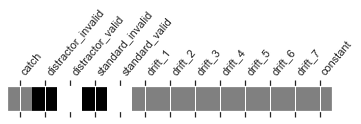

In [69]:
# plot contrast matrix of the first run (for all runs is the same as this)

plot_contrast_matrix(contrast, design_matrix=design_matrix)
plt.show()

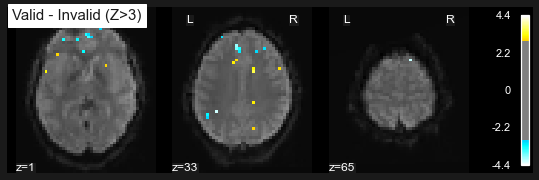

In [89]:
# effect size map, z map, and plot them
eff_map = fmri_glm.compute_contrast(contrast, output_type='effect_size')

z_map = fmri_glm.compute_contrast(contrast, output_type='z_score')

plot_stat_map(z_map, bg_img=mean_img(fmri_images[0]), threshold=3.0,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Valid - Invalid (Z>3)')
plt.show()

In [94]:
# print clusters info and coordinates
clean_map, threshold = threshold_stats_img(z_map, alpha=.0510)

table = get_clusters_table(z_map, stat_threshold=threshold, cluster_threshold=20)
print(table)

   Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0           1   7.5 -60.5  41.5   4.431927               5056
1          1a   7.5 -52.5  45.5   3.802115                   
2          1b  15.5 -72.5  41.5   3.140922                   
3          1c   7.5 -72.5  49.5   3.060233                   
4           2  51.5  11.5  37.5   3.728048               3200
5          2a  47.5  15.5  25.5   3.320461                   
6          2b  55.5  11.5   9.5   3.285314                   
7          2c  43.5   7.5  25.5   2.841392                   
8           3   3.5 -72.5 -14.5   3.649423               3328
9          3a  11.5 -60.5 -10.5   3.112023                   
10         3b  11.5 -72.5 -14.5   2.802327                   
11         3c  15.5 -60.5   1.5   2.718254                   
12          4  31.5 -56.5  41.5   3.555649               5440
13         4a  39.5 -40.5  45.5   3.495700                   
14         4b  35.5 -64.5  41.5   3.325385                   
15      